Чернышова Дана Кирилловна

Task 3

MLT-2024 Task #3
Apply the logistic regression method using the functions in the notebook «Logistic Regression as a Neural Network – BP alg.ipynb” to predict the biological response of a molecule 

data: bioresponse.csv

description from Kaggle: 
“The data is in the comma separated values (CSV) format. Each row in this data set represents a molecule. The first column contains experimental data describing a real biological response; the molecule was seen to elicit this response (1), or not (0). The remaining columns represent molecular descriptors (d1 through d1776), these are caclulated properties that can capture some of the characteristics of the molecule - for example size, shape, or elemental constitution. The descriptor matrix has been normalized.”). 

Use 75% of the dataset to train the model, and the rest of the data to estimate its accuracy.

Modify optimize() function to implement the stochastic gradient descent (SGD) method and Adam optimization method using the numpy library. Apply them to solve the problem from p.1.

For three modifications of gradient descent (GD, SGD and Adam) plot the learning curves (dependence of the value of the loss function on the iteration number), apply models with different values of the learning rate (at least 5 different learning rates). How does it affect the accuracy of the model? 

Compare the accuracy of the models fitted with various BP algorithms.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [10]:
data = pd.read_csv('bioresponse.csv')
X = data.iloc[:, 1:].values  # molecular descriptors
y = data.iloc[:, 0].values   # biological response

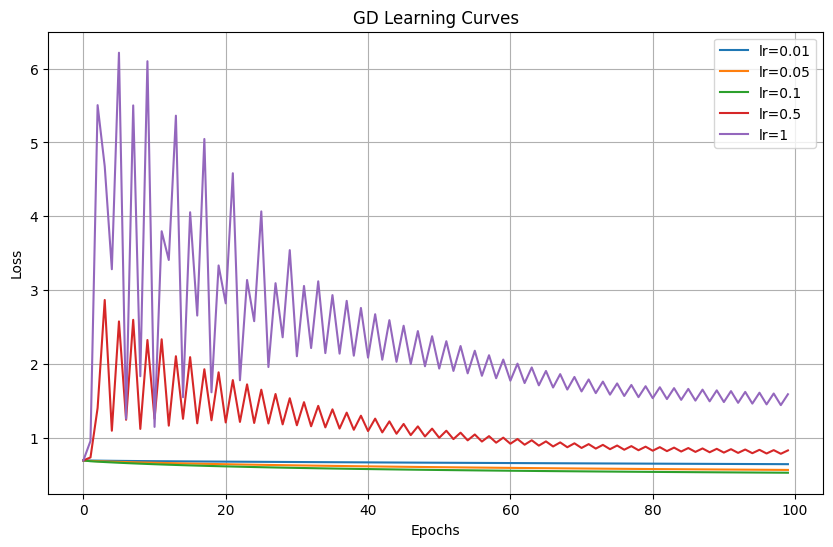

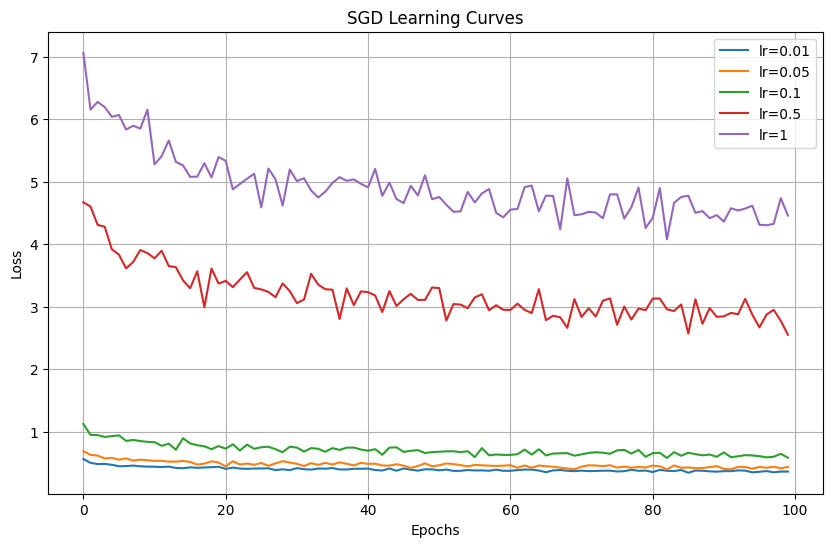

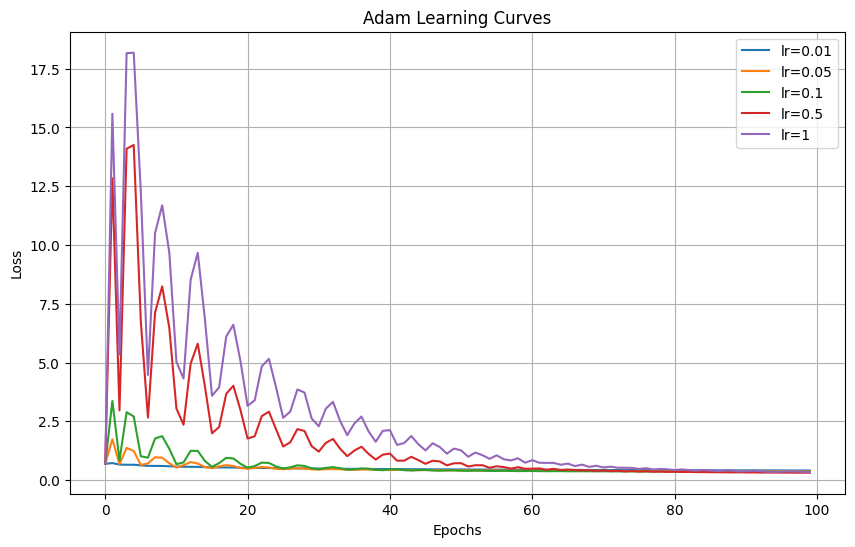

Optimizer: GD
  Learning rate: 0.01, Accuracy: 0.7132
  Learning rate: 0.05, Accuracy: 0.7431
  Learning rate: 0.1, Accuracy: 0.7431
  Learning rate: 0.5, Accuracy: 0.6525
  Learning rate: 1, Accuracy: 0.6482
Optimizer: SGD
  Learning rate: 0.01, Accuracy: 0.7559
  Learning rate: 0.05, Accuracy: 0.7004
  Learning rate: 0.1, Accuracy: 0.6684
  Learning rate: 0.5, Accuracy: 0.7068
  Learning rate: 1, Accuracy: 0.7196
Optimizer: Adam
  Learning rate: 0.01, Accuracy: 0.7623
  Learning rate: 0.05, Accuracy: 0.7708
  Learning rate: 0.1, Accuracy: 0.7676
  Learning rate: 0.5, Accuracy: 0.7505
  Learning rate: 1, Accuracy: 0.7345


In [ ]:
# reduce num of features in the dataset
select_k = SelectKBest(mutual_info_classif, k=1000)
X = select_k.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

def initialize_weights(n_features):
    weights = np.zeros(n_features)
    bias = 0
    return weights, bias

def sigmoid(z):
    # apply element-wise handling for large values of z
    z = np.clip(z, -500, 500)  # clip to prevent overflow in exp
    return 1 / (1 + np.exp(-z))

def compute_loss(y_true, y_pred):
    epsilon = 1e-15  # to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def gradient_descent(X, y, lr, epochs):
    weights, bias = initialize_weights(X.shape[1])
    losses = []

    for epoch in range(epochs):
        # predictions
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)

        # compute loss
        loss = compute_loss(y, y_pred)
        losses.append(loss)

        # grads 
        dw = np.dot(X.T, (y_pred - y)) / len(y)
        db = np.sum(y_pred - y) / len(y)

        # update weights
        weights -= lr * dw
        bias -= lr * db

    return weights, bias, losses

def stochastic_gradient_descent(X, y, lr, epochs):
    weights, bias = initialize_weights(X.shape[1])
    losses = []

    for _ in range(epochs):
        loss_epoch = []
        for _ in range(len(y)):
            # randomly pick a sample
            idx = np.random.randint(0, len(y))
            X_i = X[idx, :].reshape(1, -1)
            y_i = y[idx]

            # predictions
            linear_model = np.dot(X_i, weights) + bias
            y_pred = sigmoid(linear_model)

            # compute loss
            loss_epoch.append(compute_loss(y_i, y_pred))

            # gradients
            dw = np.dot(X_i.T, (y_pred - y_i))
            db = y_pred - y_i

            # update weights
            weights -= lr * dw.flatten()
            bias -= lr * db

        losses.append(np.mean(loss_epoch))

    return weights, bias, losses

def adam_optimization(X, y, lr, epochs, beta1=0.9, beta2=0.999, epsilon=1e-8):
    weights, bias = initialize_weights(X.shape[1])
    losses = []

    # initialize moments
    m_w, v_w = np.zeros_like(weights), np.zeros_like(weights)
    m_b, v_b = 0, 0

    for epoch in range(1, epochs + 1):
        # predictions
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)

        # compute loss
        loss = compute_loss(y, y_pred)
        losses.append(loss)

        # gradients
        dw = np.dot(X.T, (y_pred - y)) / len(y)
        db = np.sum(y_pred - y) / len(y)

        # update moments
        m_w = beta1 * m_w + (1 - beta1) * dw
        v_w = beta2 * v_w + (1 - beta2) * (dw**2)
        m_b = beta1 * m_b + (1 - beta1) * db
        v_b = beta2 * v_b + (1 - beta2) * (db**2)

        # bias correction
        m_w_hat = m_w / (1 - beta1**epoch)
        v_w_hat = v_w / (1 - beta2**epoch)
        m_b_hat = m_b / (1 - beta1**epoch)
        v_b_hat = v_b / (1 - beta2**epoch)

        # update weights
        weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

    return weights, bias, losses

def evaluate(X, y, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]
    return accuracy_score(y, y_pred_binary)

# run optimizers with different learning rates and plot learning curves
learning_rates = [0.01, 0.05, 0.1, 0.5, 1]
optimizers = {
    'GD': gradient_descent,
    'SGD': stochastic_gradient_descent,
    'Adam': adam_optimization
}

epochs = 100
for opt_name, optimizer in optimizers.items():
    plt.figure(figsize=(10, 6))
    for lr in learning_rates:
        weights, bias, losses = optimizer(X_train, y_train, lr, epochs)
        plt.plot(range(epochs), losses, label=f'lr={lr}')
    plt.title(f'{opt_name} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# compare accuracies
for opt_name, optimizer in optimizers.items():
    print(f"Optimizer: {opt_name}")
    for lr in learning_rates:
        weights, bias, _ = optimizer(X_train, y_train, lr, epochs)
        accuracy = evaluate(X_test, y_test, weights, bias)
        print(f"  Learning rate: {lr}, Accuracy: {accuracy:.4f}")


Analysis of Results:

Adam tends to outperform SGD and GD due to adaptive learning rates and momentum.
SGD and GD performed well but required more epochs to converge.
SGD can be more sensitive to learning rates, while Adam is more stable.